# The Libraries

In [255]:
# Basic Libraries
import pandas as pd
import numpy as np
import regex as re
import warnings


# Library for administrative data
import arff
import pickle

# Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 
import seaborn as sns
import plotly.graph_objs as go

# Machine Learning Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks


# Settings
pd.set_option('display.max_columns', None) # display all columns
warnings.filterwarnings('ignore') # ignore warnings

#Color Palette
color1='#4a86e8'
color2='#ffd966'
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [color1,color2])
custom_cmap2 =  [color1,color2]

# Helper Functions

In [180]:
# overview of data
def view_data(data): 
    print(f"Data has {data.shape[0]} rows and {data.shape[1]} columns with these data types:")
    print()
    print(data.dtypes)
    print()
    print("Data row sample and full columns:")
    return data.sample(5)

# checks for dupplicates, NaN & empty spaces
# and returns the number of duplicates, NaN & empty spaces
def check_data(data):
    duplications = data.duplicated().sum()
    nan_values = data.isna().sum()
    empty_spaces = data.eq(' ').sum()
    print(f"There are {duplications} duplicate rows, {nan_values.values.sum()} empty rows and {empty_spaces.values.sum()} empty spaces")
    if duplications > 0:
        print("Duplicate Rows:")
        print(data[data.duplicated(keep=False)])
    if nan_values.values.sum() > 0:
        print("NaN Rows:")
        for x in nan_values[nan_values > 0].index:
            perc = str(round(df[x].isna().sum() / len(df) * 100, 2))
            print(f"{perc}% of NaNs in the {x} column")
    if empty_spaces.values.sum() > 0:
        print("Empty Rows:")

# given a dataframe a function to create a subset of columns
def create_subset(data, columns):
    subset = data[columns]
    return subset

# create num and cat dataframes with threshold
# num, cat = separate_numerical_categorical(df, 18)
def separate_numerical_categorical(df, threshold=18):
    cat = df.select_dtypes(include="object")
    num = df.select_dtypes(include="number") 
    cat_num = num.loc[:, num.nunique() < threshold]  
    num = num.drop(columns=cat_num.columns)  
    cat = pd.concat([cat, cat_num], axis=1)  
    return num, cat

# Create a bar chart showing the percentage of NaN values in each column of the DataFrame.
def create_plot_of_nan(df):
    perc_missing = df.isna().mean() * 100
    df_table = pd.DataFrame(perc_missing).T
    df_table.index = ['Percent Missing']
    # Sample data
    categories = list(df_table.keys())
    values = df_table.iloc[0].values

    # Create a bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(categories, values, color=color1)

    # Add titles and labels
    plt.title('Bar Chart of NaN values', fontsize=14)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Percentag of NaN', fontsize=12)
    plt.xticks(rotation=45, ha='right') 

    # Show grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Display the plot
    plt.show()

def create_distribution_plot(num,type):
    if type == 'distribution':
        nrows, ncols = 4,4 # how many subplots per row and column

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))

        axes = axes.flatten() #it converts the array from a shape of 2D (nrows, ncols) to a shape of 1D(nrows*ncols,)


        for i, ax in enumerate(axes): #i is getting the index, ax the axis object
            if i >= len(num.columns):  # avoids showing empty plots (e.g. above we have 16 suplots but only 13 columns)
                ax.set_visible(False) 
                continue                
            ax.hist(num.iloc[:, i], bins=40, color=color2, edgecolor='black')
            ax.set_title(num.columns[i], fontsize=15)

        plt.tight_layout()
        plt.show()

    elif type == 'outliers':
        nrows, ncols = 5, 4
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))
        axes = axes.flatten()

        for i, ax in enumerate(axes):
            if i >= len(num.columns):
                ax.set_visible(False)
                continue
            ax.boxplot(
                num.iloc[:, i].dropna(), vert=False, patch_artist=True,
                boxprops={'facecolor': color1, 'color': 'black'},  # Correct usage here
                medianprops={'color': 'yellow'},
                whiskerprops={'color': 'black'},
                capprops={'color': 'black'},
                flierprops={'marker': 'o', 'color': 'red', 'markersize': 5}
            )
            ax.set_title(num.columns[i], fontsize=14)
            ax.tick_params(axis='x', labelsize=14)

        plt.tight_layout()
        plt.show()

def create_heatmap_correlation(df, cols, type):

    if type == 'chi-square':
        corr_mat_chi = {}
        for i in cols:
            # inner dictionary for each column i
            corr_mat_chi[i] = {}
            for j in cols:
                _, pvalue,_,_ = chi2_contingency(pd.crosstab(df[i], df[j]))
            corr_mat_chi[i][j] = round(pvalue,2)
        df_table = pd.DataFrame(corr_mat_chi)
        print(df_table)
        # heatmap
        plt.figure(figsize=(8,6))
        sns.heatmap(df_table, annot=True, cmap=custom_cmap, fmt=".2f")
        plt.title('Heatmap of Chi-Square P Value')
        plt.show()

    elif type == 'cramers_v':
        dict= {}
        for i in cols:
            # inner dictionary for each column i
            dict[i] = {}
            for j in cols:
                cramer_v = association(pd.crosstab(df[i], df[j]), method='cramer')
            dict[i][j] = round(cramer_v,2)
        df_table = pd.DataFrame(dict)

        # heatmap
        plt.figure(figsize=(8,6))

        sns.heatmap(df_table, annot=True, cmap=custom_cmap, fmt=".2f")
        plt.title("Heatmap of Cramér's V")
        plt.show()
        


### Loading the titanic dataset

In [181]:
# source of information: https://www.openml.org/search?type=data&sort=runs&id=40945&status=active

# Use liac-arff to read the ARFF file
with open('../data/titanic.arff', 'r') as file:
    arff_content = arff.load(file)

# Extract data and attributes
data = arff_content['data']
attribute_names = [attribute[0] for attribute in arff_content['attributes']]

# Create a pandas DataFrame
data = pd.DataFrame(data, columns=attribute_names)
df = data.copy()

In [182]:
view_data(df)

Data has 1309 rows and 14 columns with these data types:

pclass       float64
survived      object
name          object
sex           object
age          float64
sibsp        float64
parch        float64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

Data row sample and full columns:


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
696,3.00,0,"Cacic, Miss. Manda",female,21.00,0.00,0.00,315087,8.66,None,S,None,NaN,None
889,3.00,1,"Johansson Palmquist, Mr. Oskar Leander",male,26.00,0.00,0.00,347070,7.78,None,S,15,NaN,None
446,2.00,1,"Hocking, Miss. Ellen 'Nellie'",female,20.00,2.00,1.00,29105,23.00,None,S,4,NaN,"Cornwall / Akron, OH"
626,3.00,0,"Andersson, Miss. Ida Augusta Margareta",female,38.00,4.00,2.00,347091,7.78,None,S,None,NaN,"Vadsbro, Sweden Ministee, MI"
893,3.00,0,"Johansson, Mr. Nils",male,29.00,0.00,0.00,347467,7.85,None,S,None,NaN,None


In [183]:
check_data(df)

There are 0 duplicate rows, 3855 empty rows and 0 empty spaces
NaN Rows:
20.09% of NaNs in the age column
0.08% of NaNs in the fare column
77.46% of NaNs in the cabin column
0.15% of NaNs in the embarked column
62.87% of NaNs in the boat column
90.76% of NaNs in the body column
43.09% of NaNs in the home.dest column


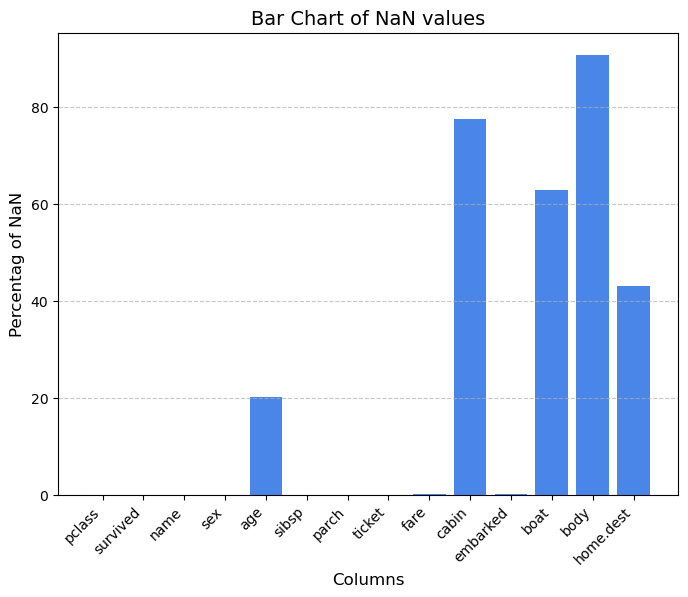

In [184]:
create_plot_of_nan(df)

In [185]:
create_subset(df, ['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin'])

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin
0,1.00,1,"Allen, Miss. Elisabeth Walton",female,29.00,0.00,0.00,24160,211.34,B5
1,1.00,1,"Allison, Master. Hudson Trevor",male,0.92,1.00,2.00,113781,151.55,C22 C26
2,1.00,0,"Allison, Miss. Helen Loraine",female,2.00,1.00,2.00,113781,151.55,C22 C26
3,1.00,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1.00,2.00,113781,151.55,C22 C26
4,1.00,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1.00,2.00,113781,151.55,C22 C26
...,...,...,...,...,...,...,...,...,...,...
1304,3.00,0,"Zabour, Miss. Hileni",female,14.50,1.00,0.00,2665,14.45,None
1305,3.00,0,"Zabour, Miss. Thamine",female,NaN,1.00,0.00,2665,14.45,None
1306,3.00,0,"Zakarian, Mr. Mapriededer",male,26.50,0.00,0.00,2656,7.22,None
1307,3.00,0,"Zakarian, Mr. Ortin",male,27.00,0.00,0.00,2670,7.22,None


### Can we drop 20% of empty age rows? Or rather the age column?

In [186]:
df[df.age.isna()].groupby(['pclass','survived']).size()

pclass  survived
1.00    0            20
        1            19
2.00    0            12
        1             4
3.00    0           158
        1            50
dtype: int64

### No, we cannot drop age. It seems important.

### Can we drop the empty fare rows? Yes, as is just 1

In [187]:
df[df.fare.isna()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1225,3.00,0,"Storey, Mr. Thomas",male,60.50,0.00,0.00,3701,NaN,None,S,None,261.00,None


In [188]:
df = df.dropna(subset=['fare'])

### Can we drop the empty embarked rows? Yes, as is just 2

In [189]:
df[df.embarked.isna()]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
168,1.00,1,"Icard, Miss. Amelie",female,38.00,0.00,0.00,113572,80.00,B28,None,6,NaN,None
284,1.00,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0.00,0.00,113572,80.00,B28,None,6,NaN,"Cincinatti, OH"


In [190]:
df = df.dropna(subset=['embarked'])

### Transforming Title/Name

In [191]:
# function to extract the title from the name
def extract_title(name):
    chunks = name.split(",")
    return chunks[1].split(".")[0].strip()

In [192]:
# creating a new column title from the name column
df["title"] = df["name"].apply(extract_title)

### Filling missing Age columns based on median of corresponding title

In [193]:
# making a dictionary with the mean age of each title
keys = df.groupby("title")["age"].mean().round(2).index
values = df.groupby("title")["age"].mean().round(2).values
mean_ages = {key: float(value) for key, value in zip(keys, values)}
# filling the NaN values in the age column with the mean age of the title
age_by_title = df["title"].map(mean_ages)
df["age"] = df["age"].fillna(age_by_title)

### Gender encoding

In [194]:
# sex encoding
df["sex"] = df["sex"].map({"male": 0, "female": 1})

### Separating numerical and categorical

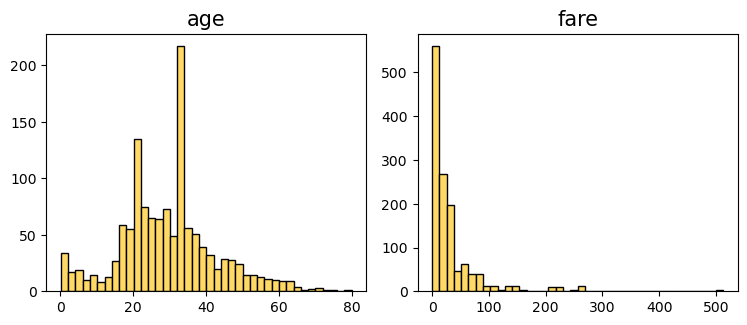

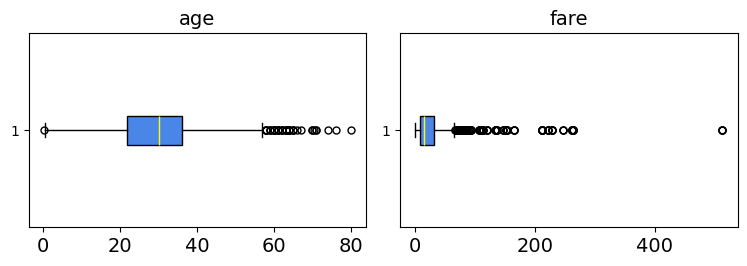

In [195]:
num, cat = separate_numerical_categorical(df, 18)
create_distribution_plot(create_subset(df, ['age', 'fare']), 'distribution')
create_distribution_plot(create_subset(df, ['age', 'fare']), 'outliers')

### Correlations Numerical

In [196]:
print(f"Pearson/linear correlation of 'survival with age' {df.survived.corr(df.age):.2f}, 'survival with fare': {df.survived.corr(df.fare):.2f} and 'fare with age': {df.fare.corr(df.age):.2f}")

Pearson/linear correlation of 'survival with age' -0.07, 'survival with fare': 0.24 and 'fare with age': 0.17


Overall corellations of numerical columns with the target are not linear.

### Correlations Categorical

In [197]:
"""
cat_cols = ['sex', 'cabin', 'embarked', 'pclass','sibsp',
       'parch','survived']
create_heatmap_correlation(df,cat_cols, 'chi-square')
create_heatmap_correlation(df,cat_cols, 'cramers_v')
"""

"\ncat_cols = ['sex', 'cabin', 'embarked', 'pclass','sibsp',\n       'parch','survived']\ncreate_heatmap_correlation(df,cat_cols, 'chi-square')\ncreate_heatmap_correlation(df,cat_cols, 'cramers_v')\n"

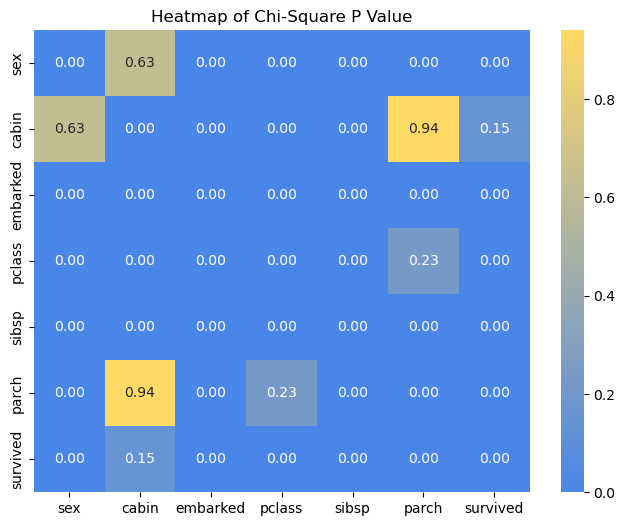

In [198]:
# creating the table manually
cat_columns = ['sex', 'cabin', 'embarked', 'pclass','sibsp',
       'parch','survived']
corr_mat_chi = {}
for i in cat_columns:
    # inner dictionary for each column i
    corr_mat_chi[i] = {}
    for j in cat_columns:
       _, pvalue,_,_ = chi2_contingency(pd.crosstab(cat[i], cat[j]))
       corr_mat_chi[i][j] = round(pvalue,2)
df_table = pd.DataFrame(corr_mat_chi)
plt.figure(figsize=(8,6))
sns.heatmap(df_table, annot=True, cmap=custom_cmap, fmt=".2f")
plt.title('Heatmap of Chi-Square P Value')
plt.show()



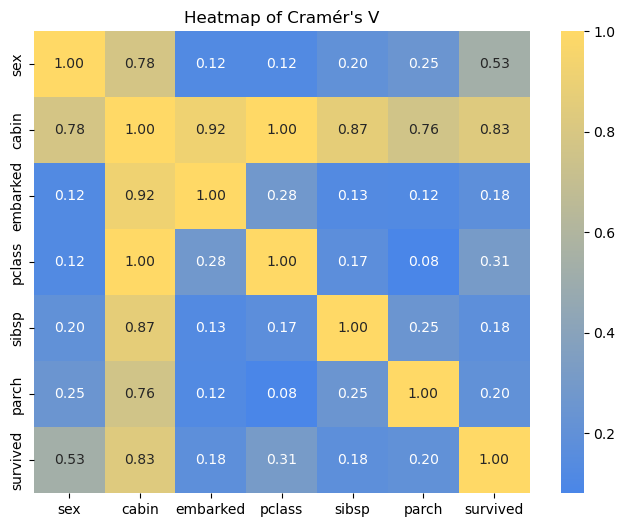

In [199]:
# creating the table manually
cat_columns = ['sex', 'cabin', 'embarked', 'pclass','sibsp',
       'parch','survived']
dict= {}
for i in cat_columns:
    # inner dictionary for each column i
    dict[i] = {}
    for j in cat_columns:
       cramer_v = association(pd.crosstab(cat[i], cat[j]), method='cramer')
       dict[i][j] = round(cramer_v,2)
df_table = pd.DataFrame(dict)

 # heatmap
plt.figure(figsize=(8,6))

sns.heatmap(df_table, annot=True, cmap=custom_cmap, fmt=".2f")
plt.title("Heatmap of Cramér's V")
plt.show()



# Machine Learning

### Set up X and Y test and train split

In [200]:
ml_df = create_subset(df,['pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare'])

In [201]:
X = ml_df
y = df["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [202]:
print(f'100% of our data: {len(df)}.')
print(f'70% for training data: {len(X_train)}.')
print(f'30% for test data: {len(X_test)}.')

100% of our data: 1306.
70% for training data: 914.
30% for test data: 392.


In [203]:
ml_results = pd.DataFrame(columns=['df_type', 'ml_used', 'score'])

## Baseline Model: Logistic Regression

In [204]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)
ml_results = pd.concat([ml_results, pd.DataFrame({'df_type': ['6_columns'], 
                                                  'ml_used': ['Logistic Regression'], 
                                                  'score': [model.score(X_test, y_test)]})], ignore_index=True)

In [205]:
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]
eval_df = pd.DataFrame({"actual":y_test,"predictions":predictions, "probabilities":probabilities})
eval_df["correct"] = eval_df["actual"] == eval_df["predictions"]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       239
           1       0.78      0.67      0.72       153

    accuracy                           0.80       392
   macro avg       0.79      0.77      0.78       392
weighted avg       0.79      0.80      0.79       392



- Precision: How many times is what my model says really true?
- Recall/Sensitivity: How many times is my model able to identify the truth?
- F1-score, which is the harmonic mean of precision and recall

In [206]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn + fp)
specificity

np.float64(0.8786610878661087)


    When to Use: Specificity should be prioritized when it's important to capture true negatives. This metric is crucial when the presence of a condition is to be ruled out with certainty.
    Example Scenario: Screening a rare disease in a large population, where it's important to identify those who definitely don't have the disease.


<Figure size 800x600 with 0 Axes>

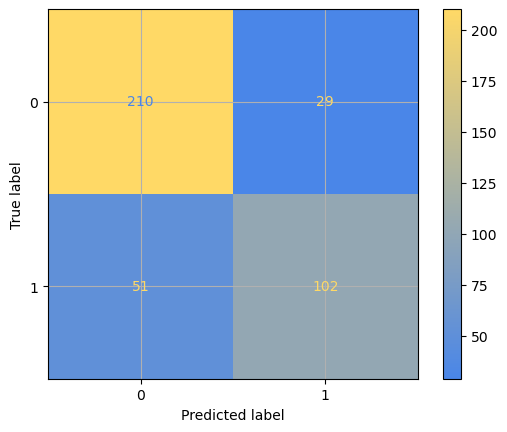

In [207]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 6))
disp.plot(cmap=custom_cmap)  
plt.grid(True)
plt.show()

In [258]:
# Retrieve the coefficient of each feature
coefficients = model.coef_

# Create a DataFrame to display the coefficients with feature names
# If you have multiple classes, iterate through them
for i, class_coefficients in enumerate(coefficients):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': class_coefficients
    })
    print(f"Class {i} Coefficients:")
    print(feature_importance)
    print("\n")

Class 0 Coefficients:
  Feature  Coefficient
0  pclass        -1.05
1     sex         2.56
2     age        -0.03
3   sibsp        -0.31
4   parch        -0.14
5    fare         0.00




## K Nearest Neighbors

In [209]:
model_kn = KNeighborsClassifier(n_neighbors=11)
model_kn.fit(X_train, y_train)
model_kn.predict(X_test)
ml_results = pd.concat([ml_results, pd.DataFrame({'df_type': ['6_columns'], 
                                                  'ml_used': ['KNN(11)'], 
                                                  'score': [model_kn.score(X_test, y_test)]})], ignore_index=True)

In [210]:
predictions_kn = model_kn.predict(X_test)
print(classification_report(y_test, predictions_kn))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       239
           1       0.68      0.52      0.59       153

    accuracy                           0.72       392
   macro avg       0.71      0.68      0.69       392
weighted avg       0.71      0.72      0.71       392



<Figure size 800x600 with 0 Axes>

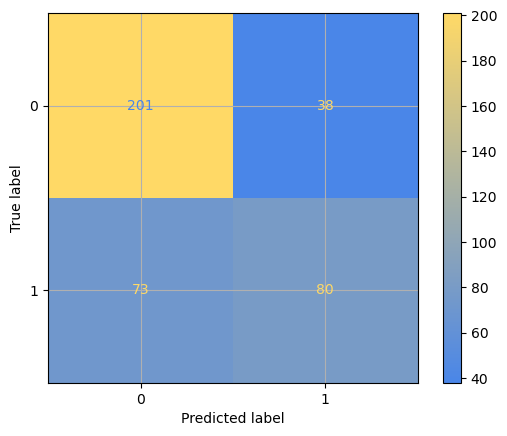

In [211]:
cm = confusion_matrix(y_test, predictions_kn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(8, 6))
disp.plot(cmap=custom_cmap)  
plt.grid(True)
plt.show()

In [212]:
n_neighbors = range(1, 30)
test = []
train = []

for k in n_neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    test.append(model.score(X_test,y_test))
    train.append(model.score(X_train,y_train))

In [213]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(n_neighbors), y=train, name='Training Accuracy', marker={'color':color1}))
fig.add_trace(go.Scatter(x=list(n_neighbors), y=test, name='Testing Accuracy', line={'color':color2}))
fig.update_layout(xaxis_title='Max Neighboors', yaxis_title='Accuracy', title='')
fig.show()

### GradientBoostingClassifier

In [214]:
model_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
model_gbc.fit(X_train, y_train)
ml_results = pd.concat([ml_results, pd.DataFrame({'df_type': ['6_columns'],
                                                  'ml_used': ['Gradient Boosting'], 
                                                  'score': [model_gbc.score(X_test, y_test)]})], ignore_index=True)

In [215]:
predictions_gbc = model_gbc.predict(X_test)
print(classification_report(y_test, predictions_gbc))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       239
           1       0.74      0.71      0.72       153

    accuracy                           0.79       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.79      0.79      0.79       392



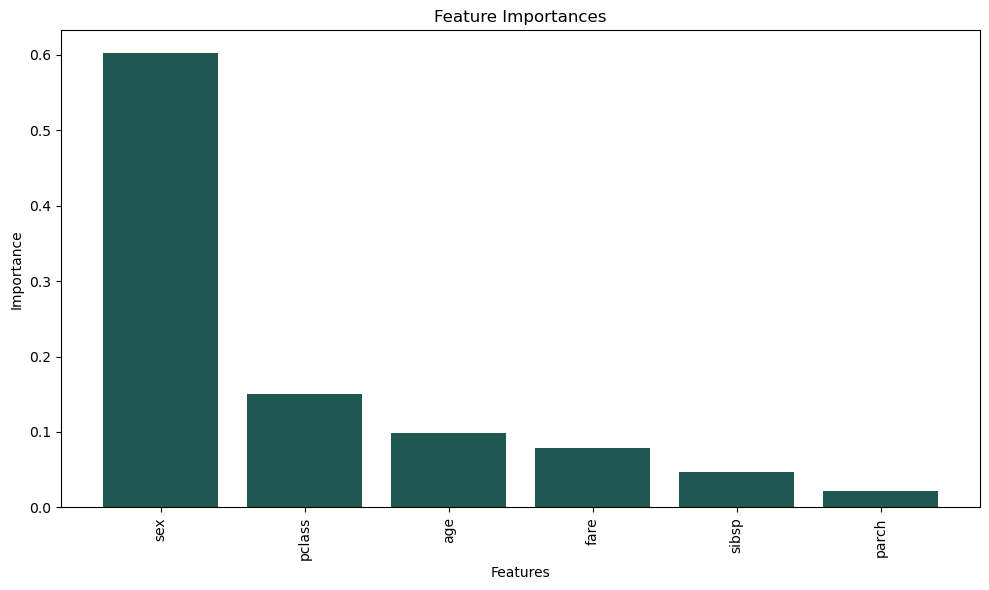

In [216]:
feature_names = list(X_train.columns)
importances = model_gbc.feature_importances_
indices = np.argsort(importances)[::-1] # sorts indices of importances in descending order

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='#1f5851')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Normalisation/Standardisation

I decided for the Normalisation of Fare (due to high outliers and exponential distribution) and the Standardisation of Age (as already not too far from a normal gaussian distribution)

In [217]:
ml_df_scaled = ml_df.copy()

In [218]:
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

In [219]:
ml_df_scaled['age'] = scaler_standard.fit_transform(df[['age']])
ml_df_scaled['fare'] = scaler_minmax.fit_transform(df[['fare']])

In [220]:
X = ml_df_scaled
y = df["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Class imbalance

In [221]:
#  Apply SMOTE only on training data
smote = SMOTE()
X_train_oversampling, y_train_oversampling = smote.fit_resample(X_train, y_train)

# Display class distribution after SMOTE
print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", pd.Series(y_train_oversampling).value_counts())

Original class distribution:
 survived
0    569
1    345
Name: count, dtype: int64
Resampled class distribution:
 survived
1    569
0    569
Name: count, dtype: int64


In [222]:
#  Apply TomekLinks only on training data
tl = TomekLinks(sampling_strategy='majority')
X_train_undersampling, y_train_undersampling = tl.fit_resample(X_train, y_train)

# Display class distribution after SMOTE
print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", pd.Series(y_train_undersampling).value_counts())

Original class distribution:
 survived
0    569
1    345
Name: count, dtype: int64
Resampled class distribution:
 survived
0    518
1    345
Name: count, dtype: int64


In [223]:
# Regression
model_unders = LogisticRegression(random_state=42)
model_unders.fit(X_train_undersampling, y_train_undersampling)
ml_results = pd.concat([ml_results, pd.DataFrame({'df_type': ['scaled+tomek_links'],
                                                  'ml_used': ['Logistic Regression'], 
                                                  'score': [model_unders.score(X_test, y_test)]})], ignore_index=True)

In [224]:
# KNN
model_kn_under = KNeighborsClassifier(n_neighbors=11)
model_kn_under.fit(X_train_undersampling, y_train_undersampling)
ml_results = pd.concat([ml_results, pd.DataFrame({'df_type': ['scaled+tomek_links'],
                                                  'ml_used': ['KNN(11)'], 
                                                  'score': [model_kn_under.score(X_test, y_test)]})], ignore_index=True)


In [225]:
# GBC
model_gbc_under = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
model_gbc_under.fit(X_train_undersampling, y_train_undersampling)
ml_results = pd.concat([ml_results, pd.DataFrame({'df_type': ['scaled+tomek_links'],
                                                  'ml_used': ['Gradient Boosting'], 
                                                  'score': [model_gbc_under.score(X_test, y_test)]})], ignore_index=True)

In [226]:
# printing all the Machine Learning results with accuracy score
ml_results

,df_type,ml_used,score
0,6_columns,Logistic Regression,0.80
1,6_columns,KNN(11),0.72
2,6_columns,Gradient Boosting,0.79
3,scaled+tomek_links,Logistic Regression,0.78
4,scaled+tomek_links,KNN(11),0.78
5,scaled+tomek_links,Gradient Boosting,0.81


For simplicity I am choosing Logistic Regression Model for the dynamic interface app

In [227]:
ml_df.to_csv('../data/ml_df.csv', index=False)

In [251]:
X = ml_df
y = df["survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [256]:
#save the model for streamlit app
with open('../data/logreg_model.pkl', 'wb') as file:
    pickle.dump(model, file)